In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import time
import math
from torch.utils import data
from tqdm.notebook import tqdm
import warnings
from train import train_epoch, eval_epoch, Dataset

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"
basis = torch.load("kernel_basis.pt")
train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_64/sample_"
img_direc = "/global/cscratch1/sd/roseyu/Eliza/Img"

## Scale

In [2]:
class scale_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, l = 3, sout = 5, activation = True):
        super(scale_conv2d, self).__init__()
        self.out_channels= out_channels
        self.in_channels = in_channels
        self.l = l
        self.sout = sout
        self.activation = activation
        self.kernel_size = kernel_size
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        weight_shape = (out_channels, l, 2, in_channels//2, kernel_size, kernel_size)
        self.stdv = math.sqrt(1. / (kernel_size * kernel_size * in_channels * l))
        self.weights = nn.Parameter(torch.Tensor(*weight_shape))
        self.reset_parameters()
        self.batchnorm = nn.BatchNorm3d(sout)# affine=False
        
    def reset_parameters(self):
        self.weights.data.uniform_(-self.stdv, self.stdv)
        if self.bias is not None:
            self.bias.data.fill_(0)
            
    def shrink_kernel(self, kernel, up_scale):
        up_scale = torch.tensor(up_scale).float()
        pad_in = (torch.ceil(up_scale**2).int())*((kernel.shape[2]-1)//2)
        pad_h = (torch.ceil(up_scale).int())*((kernel.shape[3]-1)//2)
        pad_w = (torch.ceil(up_scale).int())*((kernel.shape[4]-1)//2)
        padded_kernel = F.pad(kernel, (pad_w, pad_w, pad_h, pad_h, pad_in, pad_in))
        delta = up_scale%1
        if delta == 0:
            shrink_factor = 1
        else:
            # shrink_factor for coordinates if the kernel is over shrunk.
            shrink_factor = (((kernel.shape[4]-1))/(padded_kernel.shape[-1]-1)*(up_scale+1))
            # Adjustment to deal with weird filtering on the grid sample function.
            shrink_factor = 1.5*(shrink_factor-0.5)**3 + 0.57   

        grid = torch.meshgrid(torch.linspace(-1, 1, kernel.shape[2])*(shrink_factor**2),
                              torch.linspace(-1, 1, kernel.shape[3])*shrink_factor, 
                              torch.linspace(-1, 1, kernel.shape[4])*shrink_factor)

        grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                          grid[1].unsqueeze(0).unsqueeze(-1), 
                          grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

        new_kernel = F.grid_sample(padded_kernel, grid.to(device))
        if kernel.shape[-1] - 2*up_scale > 0:
            new_kernel = new_kernel * (kernel.shape[-1]**2/((kernel.shape[-1] - 2*up_scale)**2 + 0.01))
        return new_kernel
    
    def dilate_kernel(self, kernel, dilation):
        if dilation == 0:
            return kernel 

        dilation = torch.tensor(dilation).float()
        delta = dilation%1

        d_in = torch.ceil(dilation**2).int()
        new_in = kernel.shape[2] + (kernel.shape[2]-1)*d_in

        d_h = torch.ceil(dilation).int()
        new_h = kernel.shape[3] + (kernel.shape[3]-1)*d_h

        d_w = torch.ceil(dilation).int()
        new_w = kernel.shape[4] + (kernel.shape[4]-1)*d_h

        new_kernel = torch.zeros(kernel.shape[0], kernel.shape[1], new_in, new_h, new_w)
        new_kernel[:,:,::(d_in+1),::(d_h+1), ::(d_w+1)] = kernel
        shrink_factor = 1
        # shrink coordinates if the kernel is over dilated.
        if delta != 0:
            new_kernel = F.pad(new_kernel, ((kernel.shape[4]-1)//2, (kernel.shape[4]-1)//2)*3)

            shrink_factor = (new_kernel.shape[-1] - 1 - (kernel.shape[4]-1)*(delta))/(new_kernel.shape[-1] - 1) 
            grid = torch.meshgrid(torch.linspace(-1, 1, new_in)*(shrink_factor**2), 
                                  torch.linspace(-1, 1, new_h)*shrink_factor, 
                                  torch.linspace(-1, 1, new_w)*shrink_factor)

            grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                              grid[1].unsqueeze(0).unsqueeze(-1), 
                              grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

            new_kernel = F.grid_sample(new_kernel, grid)         
            #new_kernel = new_kernel/new_kernel.sum()*kernel.sum()
        return new_kernel[:,:,-kernel.shape[2]:]
    
    
    def forward(self, xx):
        #print(self.weights.shape, xx.shape)
        out = []
        for s in range(self.sout):
            t = np.minimum(s + self.l, self.sout)
            inp = xx[:,s:t].reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1])
            w = self.weights[:,:(t-s),:,:,:].reshape(self.out_channels, 2*(t-s), self.in_channels//2, self.kernel_size, self.kernel_size).to(device)
            
            if (s - self.sout//2) < 0:
                new_kernel = self.shrink_kernel(w, (self.sout//2 - s)/2).to(device)
            elif (s - self.sout//2) > 0:
                new_kernel = self.dilate_kernel(w, (s - self.sout//2)/2).to(device)
            else:
                new_kernel = w.to(device)
    
            new_kernel = new_kernel.reshape(self.out_channels, (t-s)*self.in_channels, new_kernel.shape[-2], new_kernel.shape[-1])
            conv = F.conv2d(inp, new_kernel, padding = ((new_kernel.shape[-2]-1)//2, (new_kernel.shape[-1]-1)//2))# bias = self.bias,
                 
            out.append(conv.unsqueeze(1))

        out = torch.cat(out, dim = 1) 
        
        # Activation Function
        if self.activation: 
            #out = self.batchnorm(out)
            out = F.leaky_relu(out)
        
        return out 
    
class scale_cnn(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim, num_layers, kernel_size, activation = False):
        super(scale_cnn, self).__init__()
        layers = [scale_conv2d(input_channels, hidden_dim, kernel_size, activation=activation)] + \
                 [scale_conv2d(hidden_dim, hidden_dim, kernel_size, activation=activation) for i in range(num_layers - 2)] + \
                 [scale_conv2d(hidden_dim, 2, kernel_size, sout = 1, activation=False)]
        self.layers = nn.Sequential(*layers)

    def forward(self, xx):
        return self.layers(xx).squeeze(1)

In [3]:
name = "ResNet_1"
min_mse = 0.8
kernel_size = 3
hidden_dim = 128
num_layers = 2
learning_rate = 0.0001
input_length = 7
output_length = 1
batch_size = 2

train_indices = list(range(0, 10))
valid_indices = list(range(10, 15))

train_set = Dataset(train_indices, input_length, 40, output_length, train_direc)
valid_set = Dataset(valid_indices, input_length, 40, 6, train_direc)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 8)
valid_loader = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 8)

In [5]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
print("Initializing...")
model = scale_cnn(activation = "leakyrelu", input_channels = input_length*2, hidden_dim = hidden_dim, num_layers = num_layers, 
                  output_channels = output_length, kernel_size = kernel_size).to(device)#
print("Done")

optimizer = torch.optim.Adam(model.parameters(), learning_rate,betas=(0.9, 0.999), weight_decay=4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
loss_fun = torch.nn.MSELoss()


train_mse = []
valid_mse = []
test_mse = []

for i in range(70):
    start = time.time()
    scheduler.step()

    model.train()
    train_mse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    model.eval()
    mse, _, _ = eval_epoch(valid_loader, model, loss_fun)
    valid_mse.append(mse)

    if valid_mse[-1] < min_mse:
        min_mse = valid_mse[-1] 
        best_model = model
        torch.save(model, name + ".pth")
    end = time.time()
    if (len(train_mse) > 45 and np.mean(valid_mse[-5:]) >= np.mean(valid_mse[-10:-5])):
            break
    print(i+1, train_mse[-1], valid_mse[-1], round((end-start)/60,5), format(get_lr(optimizer), "5.2e"), name)

Initializing...
Done
1 0.81101 0.80018 0.04402 9.00e-05 ResNet_1
2 0.69014 0.69977 0.04527 8.10e-05 ResNet_1
3 0.58726 0.60828 0.04373 7.29e-05 ResNet_1
4 0.50257 0.52985 0.04501 6.56e-05 ResNet_1
5 0.43926 0.46741 0.04194 5.90e-05 ResNet_1
6 0.3941 0.422 0.04135 5.31e-05 ResNet_1
7 0.36475 0.39174 0.04434 4.78e-05 ResNet_1
8 0.34716 0.37321 0.05506 4.30e-05 ResNet_1
9 0.33675 0.36229 0.05915 3.87e-05 ResNet_1
10 0.33124 0.35584 0.05291 3.49e-05 ResNet_1
11 0.32776 0.35223 0.05241 3.14e-05 ResNet_1
12 0.32556 0.34971 0.05171 2.82e-05 ResNet_1
13 0.32403 0.34786 0.05217 2.54e-05 ResNet_1
14 0.32282 0.34667 0.05829 2.29e-05 ResNet_1
15 0.32182 0.34548 0.06187 2.06e-05 ResNet_1
16 0.32101 0.34464 0.05353 1.85e-05 ResNet_1
17 0.32028 0.34373 0.05231 1.67e-05 ResNet_1
18 0.31968 0.34323 0.06306 1.50e-05 ResNet_1
19 0.31912 0.34264 0.06379 1.35e-05 ResNet_1
20 0.31872 0.34227 0.06263 1.22e-05 ResNet_1
21 0.3183 0.3419 0.06287 1.09e-05 ResNet_1
22 0.31795 0.34158 0.06492 9.85e-06 ResNet_1
23 

# Rot (+ UM + Scale)
- [x] test for equivariance: check Scale, Rot, UM
- [x] train on untransformed, test on Scale + Rot + UM
- [x] train on random Scale + Rot + UM, test on Scale + Rot + UM (same dataset)

In [5]:
class scale_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, l = 3, sout = 5, activation = True):
        super(scale_conv2d, self).__init__()
        self.out_channels= out_channels
        self.in_channels = in_channels
        self.l = l
        self.sout = sout
        self.activation = activation
        self.kernel_size = kernel_size
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        weight_shape = (out_channels, l, 2, in_channels//2, kernel_size, kernel_size)
        self.stdv = math.sqrt(1. / (kernel_size * kernel_size * in_channels * l))
        self.weights = nn.Parameter(torch.Tensor(*weight_shape))
        self.reset_parameters()
        self.batchnorm = nn.BatchNorm3d(sout)# affine=False
        
    def reset_parameters(self):
        self.weights.data.uniform_(-self.stdv, self.stdv)
        if self.bias is not None:
            self.bias.data.fill_(0)
            
    def shrink_kernel(self, kernel, up_scale):
        up_scale = torch.tensor(up_scale).float()
        pad_in = (torch.ceil(up_scale**2).int())*((kernel.shape[2]-1)//2)
        pad_h = (torch.ceil(up_scale).int())*((kernel.shape[3]-1)//2)
        pad_w = (torch.ceil(up_scale).int())*((kernel.shape[4]-1)//2)
        padded_kernel = F.pad(kernel, (pad_w, pad_w, pad_h, pad_h, pad_in, pad_in))
        delta = up_scale%1
        if delta == 0:
            shrink_factor = 1
        else:
            # shrink_factor for coordinates if the kernel is over shrunk.
            shrink_factor = (((kernel.shape[4]-1))/(padded_kernel.shape[-1]-1)*(up_scale+1))
            # Adjustment to deal with weird filtering on the grid sample function.
            shrink_factor = 1.5*(shrink_factor-0.5)**3 + 0.57   

        grid = torch.meshgrid(torch.linspace(-1, 1, kernel.shape[2])*(shrink_factor**2),
                              torch.linspace(-1, 1, kernel.shape[3])*shrink_factor, 
                              torch.linspace(-1, 1, kernel.shape[4])*shrink_factor)

        grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                          grid[1].unsqueeze(0).unsqueeze(-1), 
                          grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

        new_kernel = F.grid_sample(padded_kernel, grid.to(device))
        if kernel.shape[-1] - 2*up_scale > 0:
            new_kernel = new_kernel * (kernel.shape[-1]**2/((kernel.shape[-1] - 2*up_scale)**2 + 0.01))
        return new_kernel
    
    def dilate_kernel(self, kernel, dilation):
        if dilation == 0:
            return kernel 

        dilation = torch.tensor(dilation).float()
        delta = dilation%1

        d_in = torch.ceil(dilation**2).int()
        new_in = kernel.shape[2] + (kernel.shape[2]-1)*d_in

        d_h = torch.ceil(dilation).int()
        new_h = kernel.shape[3] + (kernel.shape[3]-1)*d_h

        d_w = torch.ceil(dilation).int()
        new_w = kernel.shape[4] + (kernel.shape[4]-1)*d_h

        new_kernel = torch.zeros(kernel.shape[0], kernel.shape[1], new_in, new_h, new_w)
        new_kernel[:,:,::(d_in+1),::(d_h+1), ::(d_w+1)] = kernel
        shrink_factor = 1
        # shrink coordinates if the kernel is over dilated.
        if delta != 0:
            new_kernel = F.pad(new_kernel, ((kernel.shape[4]-1)//2, (kernel.shape[4]-1)//2)*3)

            shrink_factor = (new_kernel.shape[-1] - 1 - (kernel.shape[4]-1)*(delta))/(new_kernel.shape[-1] - 1) 
            grid = torch.meshgrid(torch.linspace(-1, 1, new_in)*(shrink_factor**2), 
                                  torch.linspace(-1, 1, new_h)*shrink_factor, 
                                  torch.linspace(-1, 1, new_w)*shrink_factor)

            grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                              grid[1].unsqueeze(0).unsqueeze(-1), 
                              grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

            new_kernel = F.grid_sample(new_kernel, grid)         
            #new_kernel = new_kernel/new_kernel.sum()*kernel.sum()
        return new_kernel[:,:,-kernel.shape[2]:]
    
    
    def forward(self, xx):
        #print(self.weights.shape, xx.shape)
        out = []
        for s in range(self.sout):
            t = np.minimum(s + self.l, self.sout)
            inp = xx[:,s:t].reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1])
            w = self.weights[:,:(t-s),:,:,:].reshape(self.out_channels, 2*(t-s), self.in_channels//2, self.kernel_size, self.kernel_size).to(device)
            
            if (s - self.sout//2) < 0:
                new_kernel = self.shrink_kernel(w, (self.sout//2 - s)/2).to(device)
            elif (s - self.sout//2) > 0:
                new_kernel = self.dilate_kernel(w, (s - self.sout//2)/2).to(device)
            else:
                new_kernel = w.to(device)
    
            new_kernel = new_kernel.reshape(self.out_channels, (t-s)*self.in_channels, new_kernel.shape[-2], new_kernel.shape[-1])
            conv = F.conv2d(inp, new_kernel, padding = ((new_kernel.shape[-2]-1)//2, (new_kernel.shape[-1]-1)//2))# bias = self.bias,
                 
            out.append(conv.unsqueeze(1))

        out = torch.cat(out, dim = 1) 
        
        # Activation Function
        if self.activation: 
            #out = self.batchnorm(out)
            out = F.leaky_relu(out)
        
        return out 
    
class scale_cnn(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim, num_layers, kernel_size, activation = False):
        super(scale_cnn, self).__init__()
        layers = [scale_conv2d(input_channels, hidden_dim, kernel_size, activation=activation)] + \
                 [scale_conv2d(hidden_dim, hidden_dim, kernel_size, activation=activation) for i in range(num_layers - 2)] + \
                 [scale_conv2d(hidden_dim, 2, kernel_size, sout = 1, activation=False)]
        self.layers = nn.Sequential(*layers)

    def forward(self, xx):
        return self.layers(xx).squeeze(1)

In [20]:
name = "ResNet_1"
min_mse = 0.8
kernel_size = 3
hidden_dim = 128
num_layers = 2
learning_rate = 0.0001
input_length = 7
output_length = 1
batch_size = 2

train_indices = list(range(0, 10))
valid_indices = list(range(10, 15))

train_set = Dataset(train_indices, input_length, 40, output_length, train_direc)
valid_set = Dataset(valid_indices, input_length, 40, 6, train_direc)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 8)
valid_loader = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 8)

torch.Size([2, 7, 2, 64, 64])
torch.Size([2, 1, 2, 64, 64])


In [7]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
print("Initializing...")
model = scale_cnn(activation = "leakyrelu", input_channels = input_length*2, hidden_dim = hidden_dim, num_layers = num_layers, 
                  output_channels = output_length, kernel_size = kernel_size).to(device)#
print("Done")

optimizer = torch.optim.Adam(model.parameters(), learning_rate,betas=(0.9, 0.999), weight_decay=4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
loss_fun = torch.nn.MSELoss()


train_mse = []
valid_mse = []
test_mse = []

for i in range(70):
    start = time.time()
    scheduler.step()

    model.train()
    train_mse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    model.eval()
    mse, _, _ = eval_epoch(valid_loader, model, loss_fun)
    valid_mse.append(mse)

    if valid_mse[-1] < min_mse:
        min_mse = valid_mse[-1] 
        best_model = model
        torch.save(model, name + ".pth")
    end = time.time()
    if (len(train_mse) > 45 and np.mean(valid_mse[-5:]) >= np.mean(valid_mse[-10:-5])):
            break
    print(i+1, train_mse[-1], valid_mse[-1], round((end-start)/60,5), format(get_lr(optimizer), "5.2e"), name)

Initializing...
Done
0.53156 0.02941
0.39522 0.01002
0.33716 0.0098
0.31521 0.01202
0.28883 0.01262
0.27882 0.01001
0.27055 0.01069
0.26104 0.00994
0.25715 0.01452
0.25315 0.01106
0.25011 0.01158
0.2476 0.01193
0.24587 0.01169
0.24358 0.00886
0.24241 0.01114
0.24079 0.00791
0.23957 0.01242
0.23839 0.01206
0.23738 0.00982
0.23655 0.01136
0.23561 0.00929
0.23489 0.00975
0.2343 0.01426
0.23371 0.01175
0.23319 0.0118
0.23278 0.00974
0.23229 0.00771
0.23191 0.01097
0.23157 0.01242
0.23126 0.0097


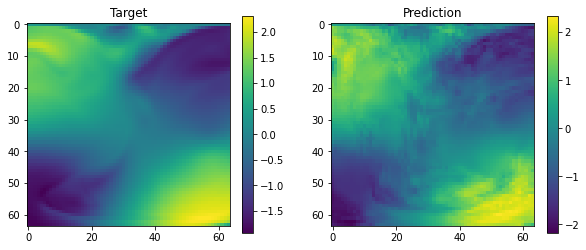

In [5]:
idx = 0
direc = 0
step = 0
fig=plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cnn_trues[idx,step,direc])
plt.title("Target")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(cnn_preds[idx,step,direc])
plt.title("Prediction")
plt.colorbar()
plt.show()
fig.savefig(img_direc + '/rot_um_scale_target_pred', bbox_inches='tight')

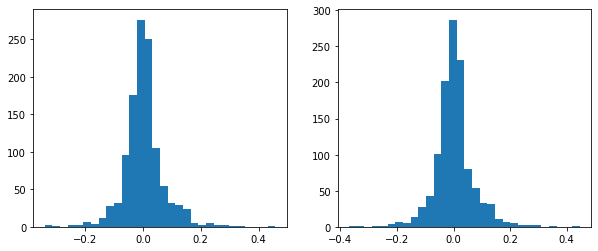

In [6]:
# Rot
fig=plt.figure(figsize=(10, 4))
initial_kernel = model.layers[0].initial_kernel.cpu().data.numpy()
trained_kernel = torch.einsum("abcd, cdefgh -> abefgh",  (model.layers[0].params, model.layers[0].basis.to(device))).cpu().data.numpy()

plt.subplot(1, 2, 1)
plt.hist(initial_kernel[:,0,:,:,0,0].flatten(), bins = 30)
plt.subplot(1, 2, 2)
plt.hist(trained_kernel[:,0,:,:,0,0].flatten(), bins = 30)
#plt.xlim(-0.5, 0.5)
plt.show()

In [7]:
# resnet = torch.load("/global/cscratch1/sd/roseyu/Eliza/Rot-UM/results.pt")

In [8]:
# plt.imshow(resnet["preds"][0,0,0])
# plt.colorbar()

In [9]:
# plt.imshow(resnet["trues"][0,0,0])
# plt.colorbar()

## Rotationaly symmetric test

In [10]:
import torchvision.transforms.functional as TF
from torchvision import transforms
PIL = transforms.ToPILImage()
TTen = transforms.ToTensor()
from PIL import Image


def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree, expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree, expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 1
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc, True)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [11]:
torch.manual_seed(10)
degree = 90

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_cnn(input_channels = 2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

rot_xx = torch.cat([rotate(xx[0,:2], degree).unsqueeze(0), rotate(xx[0,-2:], degree).unsqueeze(0)] , dim = 1)#rotate(xx[0,0], degree).unsqueeze(0)

rot_xx_out = model(rot_xx.to(device))
              
xx_out_rot = rotate((rot_xx_out[0]).cpu(), -degree)

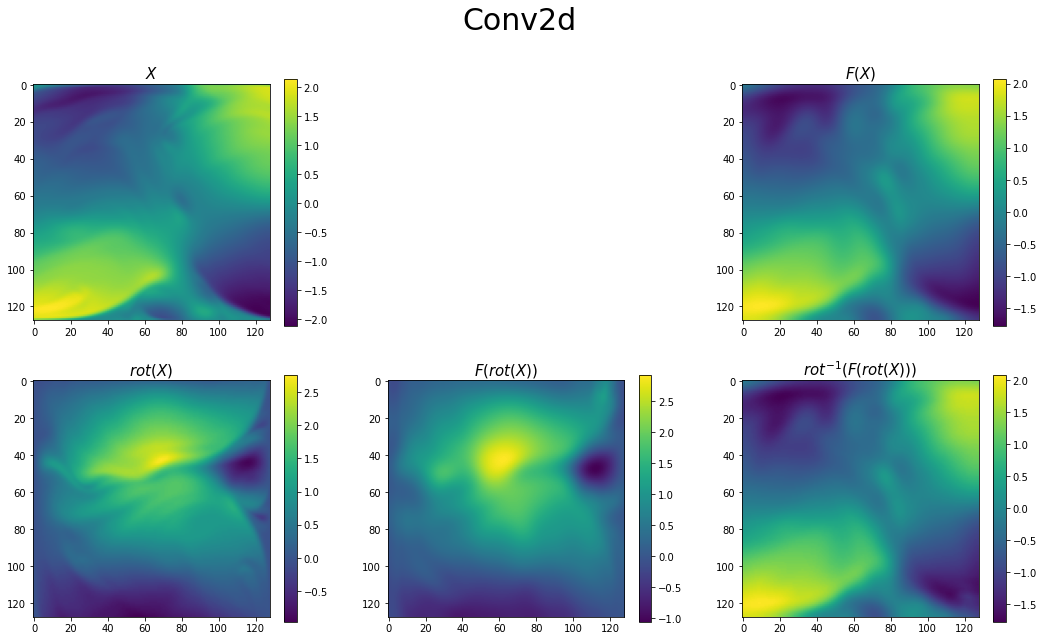

In [12]:
xx_out = model(xx.to(device))

rot_xx = torch.cat([rotate(xx[0,:2], degree).unsqueeze(0), rotate(xx[0,-2:], degree).unsqueeze(0)] , dim = 1)#rotate(xx[0,0], degree).unsqueeze(0)

rot_xx_out = model(rot_xx.to(device))
                
xx_out_rot = rotate((rot_xx_out[0]).cpu(), -degree)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(rot_xx[0, direc].cpu().data.numpy())
plt.title(r"$rot(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(rot_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(rot(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_rot[direc].cpu().data.numpy())
plt.title(r"$rot^{-1}(F(rot(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_conv2d_rot', bbox_inches='tight')

torch.Size([1, 4, 128, 128])
torch.Size([1, 4, 128, 128])


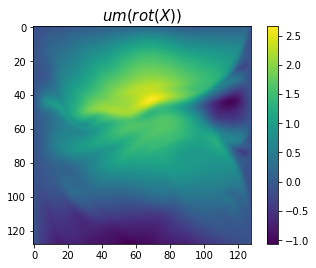

In [27]:
def uniform_motion(img, unit_vector):
    return img + torch.FloatTensor(unit_vector).repeat(img.shape[1]//2, img.shape[-1]**2).view(img.shape)
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec
um_vector = sample_spherical(1, 2)
rot_um_xx = uniform_motion(rot_xx, um_vector)
plt.imshow(rot_um_xx[0, direc].cpu().data.numpy())
plt.title(r"$um(rot(X))$", size = 15)
plt.colorbar()

In [24]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute mean squared error"""
    return torch.mean((y - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_rot_sample = xx_out_rot[direc].cpu()
print(rmse(xx_out_sample, xx_out_rot_sample))
print(mse(xx_out_sample, xx_out_rot_sample))

tensor(0.0510, grad_fn=<SqrtBackward>)
tensor(0.0026, grad_fn=<MeanBackward0>)


(array([ 925., 1627., 1850., 2677., 2772., 1632., 1493., 1503., 1319.,
         586.]),
 array([-1.7773359 , -1.3916051 , -1.0058745 , -0.6201438 , -0.2344131 ,
         0.1513176 ,  0.5370483 ,  0.92277896,  1.3085097 ,  1.6942403 ,
         2.079971  ], dtype=float32),
 <a list of 10 Patch objects>)

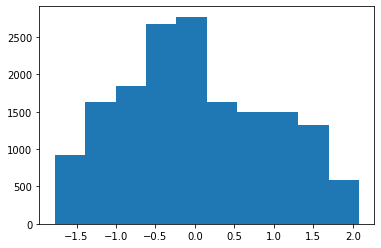

In [25]:
plt.hist(xx_out_rot[direc].cpu().data.numpy().flatten())

(array([ 861., 1464., 1921., 2497., 2938., 1684., 1464., 1582., 1329.,
         644.]),
 array([-1.7717271 , -1.3865777 , -1.0014284 , -0.61627895, -0.23112956,
         0.15401983,  0.5391692 ,  0.9243186 ,  1.309468  ,  1.6946174 ,
         2.0797668 ], dtype=float32),
 <a list of 10 Patch objects>)

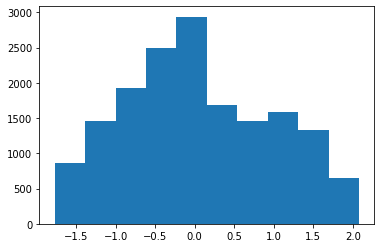

In [26]:
plt.hist(xx_out[0,direc].cpu().data.numpy().flatten())

## UM symmetric test

In [18]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [21]:
def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def uniform_motion(img, unit_vector):
    return img + torch.FloatTensor(unit_vector).repeat(img.shape[1]//2, img.shape[-1]**2).view(img.shape)

train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 1
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc, True)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [22]:
torch.manual_seed(10)
um_vector = sample_spherical(1, 2)

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_cnn(input_channels = 2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

um_xx = uniform_motion(xx, um_vector)

um_xx_out = model(um_xx.to(device))

xx_out_um = uniform_motion((um_xx_out).cpu(), -um_vector)

In [ ]:
xx_out = model(xx.to(device))

um_xx = uniform_motion(xx, um_vector)

um_xx_out = model(um_xx.to(device))

xx_out_um = uniform_motion((um_xx_out).cpu(), -um_vector)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(um_xx[0, direc].cpu().data.numpy())
plt.title(r"$um(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(um_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(um(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_um[0, direc].cpu().data.numpy())
plt.title(r"$um^{-1}(F(um(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_conv2d_um', bbox_inches='tight')

In [ ]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute root mean squared error"""
    return torch.mean((y - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_um_sample = xx_out_um[0, direc].cpu()
print(rmse(xx_out_sample, xx_out_um_sample))
print(mse(xx_out_sample, xx_out_um_sample))

In [ ]:
plt.hist(xx_out_rot[direc].cpu().data.numpy().flatten())

In [ ]:
plt.hist(xx_out[0,direc].cpu().data.numpy().flatten())

## Scale symmetric test

In [3]:
def scale(img, factor):
    scale_img = F.interpolate(img.unsqueeze(0), scale_factor = (1, factor, factor), mode="trilinear", align_corners = True).squeeze(0)
    return scale_img*(img.max() - img.min())/(scale_img.max() - scale_img.min())/factor

In [4]:
train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 1
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc, True)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [5]:
torch.manual_seed(10)
factor = np.random.uniform(0.2, 2)

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_scale_cnn(input_channels = 2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

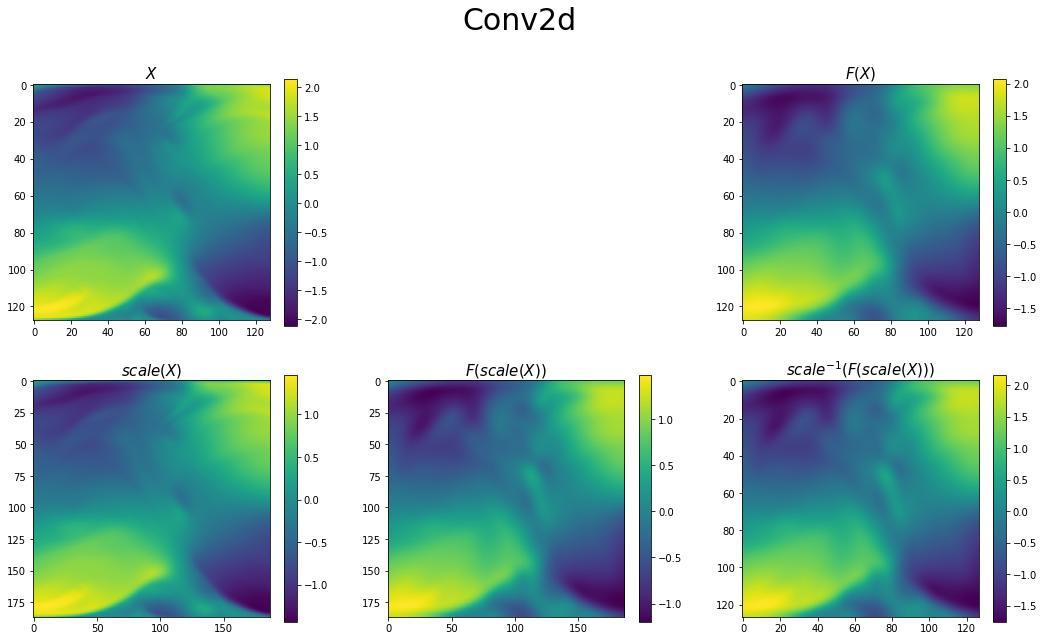

In [6]:
xx_out = model(xx.to(device))

scale_xx = scale(xx, factor)

scale_xx_out = model(scale_xx.to(device))

xx_out_scale = scale((scale_xx_out).cpu(), 1/factor)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(scale_xx[0, direc].cpu().data.numpy())
plt.title(r"$scale(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(scale_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(scale(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_scale[0, direc].cpu().data.numpy())
plt.title(r"$scale^{-1}(F(scale(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_scale_conv2d_scale', bbox_inches='tight')

In [8]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y[:y_hat.shape[0], :y_hat.shape[1]] - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute root mean squared error"""
    return torch.mean((y[:y_hat.shape[0], :y_hat.shape[1]] - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_scale_sample = xx_out_scale[0, direc].cpu()
print(rmse(xx_out_sample, xx_out_scale_sample))
print(mse(xx_out_sample, xx_out_scale_sample))

tensor(0.0597, grad_fn=<SqrtBackward>)
tensor(0.0036, grad_fn=<MeanBackward0>)


### Basic Matrices

In [2]:
def rotMat(theta, inverse = False):
    theta = torch.tensor(theta)
    sin = torch.sin(theta)
    cos = torch.cos(theta)
    mat = torch.cat([cos.unsqueeze(1), sin.unsqueeze(1)*(-1), sin.unsqueeze(1), cos.unsqueeze(1)], dim = 1).reshape(-1,2,2) 
    if inverse:
        return mat.inverse().float()
    return mat.float()


max_radius = 16
min_radius = 0.5
step_radius = 0.25
num_radius = (max_radius - min_radius-1)/step_radius
center_x = max_radius-1
center_y = max_radius-1
basis = torch.zeros(int(num_radius), 4, 31, 31, 2, 2)

Ms = [torch.tensor([[1.,0.],[0.,0.]]), torch.tensor([[0.,1.],[0.,0.]]), torch.tensor([[0.,0.],[1.,0.]]), torch.tensor([[0.,0.],[0.,1.]])]
for rad_id in range(1, int(num_radius)):
    rad = (rad_id-1) * step_radius + min_radius 
    for i in range(len(Ms)):
        for rr in np.linspace(rad - 0.25, rad + 0.25, 6):
            theta = np.linspace(0, np.pi*2, int(500*rr//2))
            x = (np.round(np.cos(theta)*rad)).astype("int32") 
            y = (np.round(np.sin(theta)*rad)).astype("int32")
            id_x = center_x - y 
            id_y = center_y + x
            out = torch.einsum("zac, zcd -> zad", (torch.einsum("zab, bc->zac", (rotMat(theta), Ms[i])), rotMat(theta, inverse = True)))
            for j in range(len(x)):
                basis[rad_id, i, id_x[j], id_y[j]] += out[j] 
                
for i in range(len(Ms)):
    basis[0, i, center_x, center_y] = 500*Ms[i]

In [3]:
basis.shape

torch.Size([58, 4, 31, 31, 2, 2])

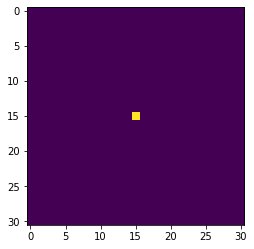

In [4]:
plt.imshow(basis[1,0,:,:,0,0])

In [5]:
basis[1,3,15,15]

tensor([[3.7050e+02, 2.5705e-06],
        [2.5705e-06, 3.7650e+02]])

In [6]:
basis[1,0,15,15]

tensor([[ 3.7650e+02, -2.5705e-06],
        [-2.5705e-06,  3.7050e+02]])

In [7]:
torch.save(basis/500, "kernel_basis.pt")

(-2, 2)

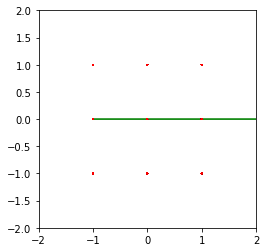

In [8]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = basis[0,0,:,:,0,0]
V = basis[0,0,:,:,1,0]

U2 = basis[0,0,:,:,0,1]
V2 = basis[0,0,:,:,1,1]

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='green')
q = ax.quiver(X, Y, U2, V2, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)

(-2, 2)

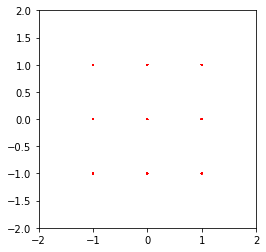

In [9]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = basis[0,0,:,:,0,1]
V = basis[0,0,:,:,1,1]

def rotate_vec(img, degree):
    #img shape 2*128*128
    img = torch.tensor(img).float()
    #2*2 2*1*128*128 -> 2*1*128*128
    
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    return img

stack = np.stack([U,V])
rot_U = rotate_vec(stack, 90)[0]
rot_V = rotate_vec(stack, 90)[1]


fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='red')

ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)

In [10]:
torch.save(basis, "kernel_basis.pt")
print("Basic Matrices Saved")

Basic Matrices Saved


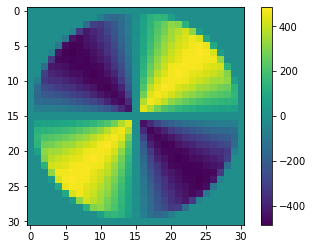

In [11]:
basis = torch.load("kernel_basis.pt")
basis = torch.sum(basis, dim = 0).data.numpy()
plt.imshow(basis[0,:,:,0,1])
plt.colorbar()

In [130]:
def rotMat(theta, inverse = False):
    theta = torch.tensor(theta)
    sin = torch.sin(theta)
    cos = torch.cos(theta)
    mat = torch.cat([cos.unsqueeze(1), sin.unsqueeze(1)*(-1), sin.unsqueeze(1), cos.unsqueeze(1)], dim = 1).reshape(-1,2,2) 
    if inverse:
        return mat.inverse().float()
    return mat.float()

basis = torch.zeros(2, 4, 3, 3, 2, 2)
Ms = [torch.tensor([[1.,0.],[0.,0.]]), torch.tensor([[0.,1.],[0.,0.]]), torch.tensor([[0.,0.],[1.,0.]]), torch.tensor([[0.,0.],[0.,1.]])]
for rad in range(1, 2):
    for i in range(len(Ms)):
        for rr in np.linspace(rad - 0.25, rad + 0.25, 6):
            theta = np.linspace(0, np.pi*2, int(500*rr//2))
            x = (np.round(np.cos(theta)*rad)).astype("int32") + 1
            y = (np.round(np.sin(theta)*rad)).astype("int32") + 1
            out = torch.einsum("zac, zcd -> zad", (torch.einsum("zab, bc->zac", (rotMat(theta), Ms[i])), rotMat(theta, inverse = True)))
            for j in range(len(x)):
                basis[rad-1, i, x[j], y[j]] += out[j]     


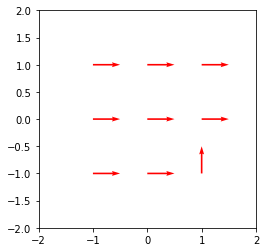

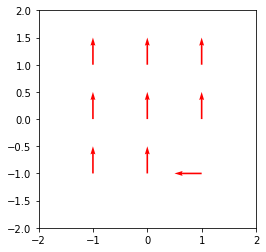

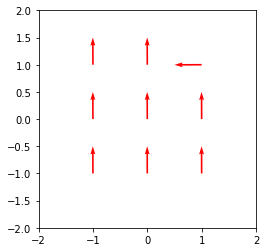

In [131]:
def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree, expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree, expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

def rotate_img(img, degree):
    img = torch.tensor(img).float()
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree,expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree,expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    #print(np.max(img), np.min(img), torch.max(rot_img), torch.min(rot_img))
    rot_img = rot_img*(mmax - mmin) + mmin
    return rot_img.cpu().data.numpy()

def rotate_vec(img, degree):
    #img shape 2*128*128
    img = torch.tensor(img).float()
    #2*2 2*1*128*128 -> 2*1*128*128
    
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    return img

import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = np.ones(x_shape)
V = np.zeros(x_shape)

#for i in range(x_shape[0]):
 #   for j in range(x_shape[1]):
       # U[i,j] = 1-i/10
        #V[i,j] = np.sin(i/20*7)

U[2,2] = 0
V[2,2] = 1


stack = np.stack([U,V])
rot_U = rotate_vec(stack, 90)[0]
rot_V = rotate_vec(stack, 90)[1]


fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='red')

ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)


fig, ax = plt.subplots()
q = ax.quiver(X, Y, rot_U, rot_V, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

stack = np.stack([rot_U,rot_V])
rot_U2 = rotate_img(stack, 90)[0]
rot_V2 = rotate_img(stack, 90)[1]
fig, ax = plt.subplots()
q = ax.quiver(X, Y, rot_U2, rot_V2, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [132]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim,  kernel_size, num_layers, activation = False, bias = True):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(input_channels*2, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, output_channels*2, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias)
        )
        self.initial_params = self.layer[0].weight.clone()
         
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
    def forward(self, xx):
        xx = xx.reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1])
        out = self.layer(xx)
        out = out.reshape(out.shape[0], out.shape[1]//2, 2, xx.shape[-2], xx.shape[-1])
        return out